# Opening and cleaning out Bin data

Note: Use L1imag/formation environment.
## Import packages

In [1]:
import quantities as pq
import numpy as np
import neo
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
import scipy
from scipy import interpolate
from scipy import fftpack
from scipy import signal
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

## Load data

WARNING: Absurd here, just temporary loading to see if and how I can access the data

In [3]:
folder_base = Path('/Users/ahay/Documents/DATA/OPNE/ArchTshort/')


filename = folder_base / f'YSQT1_GreenStimOn2_g0_t0.exported.nidq.bin'
All = np.fromfile(filename, dtype="int16")
All = All.reshape(-1,12)


sampling_rate = 25000 # Hz
new_sampling_rate = 1000 # Hz
nmberchann = All.shape
datalen = All.size/ nmberchann[1]
Nmber_points = int(datalen * new_sampling_rate / sampling_rate)
print(datalen, Nmber_points)
DS_GoodChannels = signal.resample(All, Nmber_points, axis = 0)
Good_channels_filtered = DS_GoodChannels

filenameC = folder_base / f'YS2.npy'
np.save(filenameC, Good_channels_filtered)


23474447.0 938977


In [2]:
folder_base = Path('/Users/ahay/Documents/DATA/OPNE/ArchTshort/')
filename = folder_base / f'OD1.npy'
All1 = np.load(filename)
filename = folder_base / f'OD2.npy'
All2 = np.load(filename)
filename = folder_base / f'YS1.npy'
All3 = np.load(filename)
filename = folder_base / f'YS2.npy'
All4 = np.load(filename)

All1.shape

(995982, 12)

In [3]:
OD1pfc = All1[:, 4]-All1[:, 5]
OD1ca1 = All1[:, 0]-All1[:, 1]
OD1ttl = All1[:, 11]
OD1emg = All1[:, 6]

OD2pfc = All2[:, 4]-All2[:, 5]
OD2ca1 = All2[:, 0]-All2[:, 1]
OD2ttl = All2[:, 11]
OD2emg = All2[:, 6]


In [31]:
folder_base = Path('/Users/ahay/Documents/DATA/OPNE/ArchTlong/')
filename = folder_base / f'OD.npy'
All1 = np.load(filename)
filename = folder_base / f'PS.npy'
All2 = np.load(filename)
filename = folder_base / f'PSr.npy'
All3 = np.load(filename)
filename = folder_base / f'RS.npy'
All4 = np.load(filename)
filename = folder_base / f'RT.npy'
All5 = np.load(filename)
filename = folder_base / f'YS.npy'
All6 = np.load(filename)
filename = folder_base / f'RT2.npy'
All52 = np.load(filename)
filename = folder_base / f'YS2.npy'
All62 = np.load(filename)

########################################################################################################################
##########################      From the mice, take the TTL, EMG, PFC and M1 for analysis       ########################
########################################################################################################################

ODpfc = All1[:, 4]-All1[:, 5]
ODm1 = All1[:, 9]-All1[:, 10]
ODttl = All1[:, 11]
ODemg = All1[:, 6]

PSpfc = All2[:, 4]-All2[:, 5]
PSm1 = All2[:, 0]-All2[:, 1]
PSttl = All2[:, 9]
PSemg = All2[:, 6]

PSRpfc = All3[:, 3]-All3[:, 4]
PSRm1 = All3[:, 1]-All3[:, 2]
PSRttl = All3[:, 9]
PSRemg = All3[:, 5]

RSpfc = All4[:, 4]-All4[:, 5]
RSm1 = All4[:, 0]-All4[:, 1]
RSttl = All4[:, 14]
RSemg = All4[:, 6]

RTpfc = All5[:, 7]-All5[:, 8]
RTm1 = All5[:, 5]-All5[:, 6]
RTttl = All5[:, 9]
RTemg = All5[:, 0]

YSpfc = All6[:, 4]-All6[:, 5]
YSm1 = All6[:, 7]-All6[:, 8]
YSttl = All6[:, 11]
YSemg = All6[:, 6]

RT2pfc = All52[:, 7]-All52[:, 8]
RT2m1 = All52[:, 5]-All52[:, 6]
RT2ttl = All52[:, 9]
RT2emg = All52[:, 0]

YS2pfc = All62[:, 4]-All62[:, 5]
YS2m1 = All62[:, 7]-All62[:, 8]
YS2ttl = All62[:, 11]
YS2emg = All62[:, 6]

In [9]:
fs = 1000
triggertimeS = []
triggertimeF = []
for i in range(len(OD1emg)-1):
    if OD1ttl[i] >= -5000 and OD1ttl[i+1] < -5000:
        triggertimeS.append(i)
    elif OD1ttl[i] < -5000 and OD1ttl[i+1] > -5000:
        triggertimeF.append(i)



# index = 0
# for i in triggertimeS:
#     index = index + 1
#     pfcON = YS2pfc[i+100:i+29900]
#     pfcOFF = YS2pfc[i+30100:i+59900]

#     f, Pxx_denON = signal.welch(pfcON, fs, nperseg=1024)
#     f, Pxx_denOFF = signal.welch(pfcOFF, fs, nperseg=1024)
#     if index == 5:
#         freq = f
#         spectreON = Pxx_denON
#         spectreOFF = Pxx_denOFF
#     elif index > 5:
#         freq = freq + f
#         spectreON = spectreON + Pxx_denON
#         spectreOFF = spectreOFF + Pxx_denOFF

# freq = freq/index
# YS2spectreON = spectreON/index
# YS2spectreOFF = spectreOFF/index


In [15]:
data = np.zeros((len(triggertimeS),2))
data[:, 0] = triggertimeS
data[:, 1] = triggertimeF
All_SWR = pd.DataFrame(data, columns = ['Start', 'End'])
filename3 = folder_base / f'TTLproperties.csv'
All_SWR.to_csv(filename3, sep = ',')

In [106]:
SpectreON = ODspectreON + PSspectreON + PSRspectreON + RSspectreON + RT2spectreON + YS2spectreON
SpectreOFF = ODspectreOFF + PSspectreOFF + PSRspectreOFF + RSspectreOFF + RT2spectreOFF + YS2spectreOFF


In [16]:
spectreONswr = spectreON[120:251]
spectreOFFswr = spectreOFF[120:251]
OD2powerON = sum(spectreONswr)
OD2powerOFF = sum(spectreOFFswr)

In [12]:
len(spectreON)

251

In [35]:

a = [ODpowerON,ODpowerOFF]


fig, ax = plt.subplots()

fruits = ['ON', 'OFF']
counts = a

ax.bar(fruits, counts)
ax.set_ylabel('laser status')
ax.set_title('power on swr')


plt.show()

NameError: name 'ODpowerON' is not defined

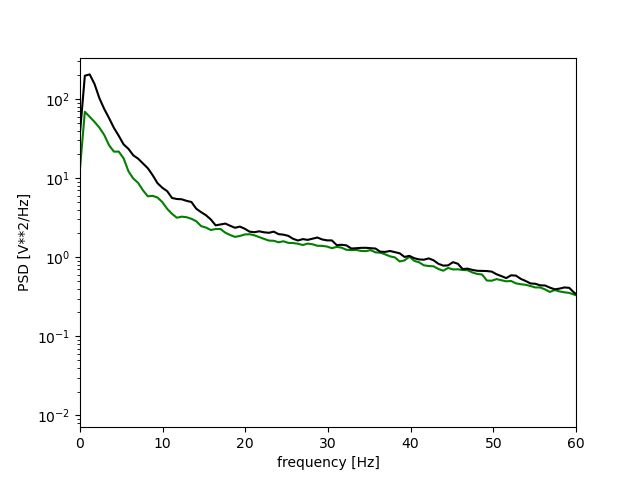

In [127]:
plt.close()

plt.semilogy(freq, PSRspectreON, color='g')
plt.semilogy(freq, PSRspectreOFF, color='k')
plt.xlim([00, 60])
#plt.ylim([0, 7000])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

filename = folder_base / f'logodPSD30s.svg'
#plt.savefig(filename, format="svg")

In [37]:
print(triggertimeS)
print(triggertimeF)



[26269, 129966, 233653, 337334, 441014, 544702, 648383, 752071, 855745, 959451]
[56269, 159966, 263654, 367335, 471015, 574703, 678384, 782072, 885746, 989451]


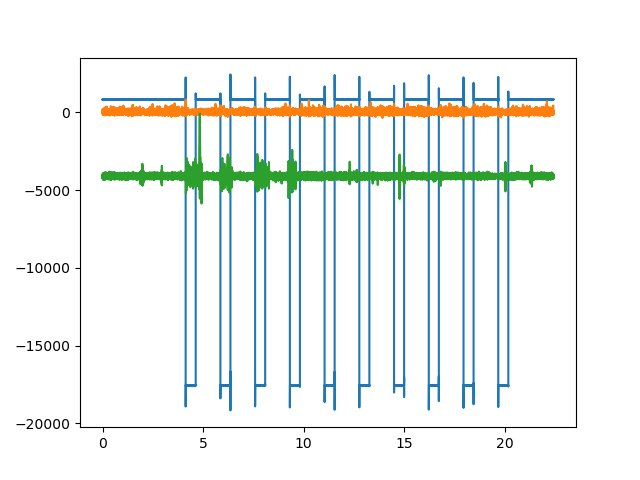

In [88]:
plt.close()
fs = 1000
times = np.arange(0, YS2emg.size/fs, 1./fs)
timesmin = np.arange(0, YS2emg.size/fs/60, 1./fs/60)
fig, ax = plt.subplots()
ax.plot(timesmin, YS2ttl)
ax.plot(timesmin, YS2pfc)
ax.plot(timesmin, YS2emg - 4000)

### Distribute channels.

EMG = 0, BLA left = 1-2, BLA right = 3-4, PFC left = 5-6, PFC right = 9-10, CA1 = 7-8, TTL = 11

WARNING: this has to be adjusted for every mouse. In the future, add a cell at the beginning to enter these parameters

In [8]:

    # Distribute
OD1pfc = All1[:, 4]-All1[:, 5]
OD1ca1 = All1[:, 0]-All1[:, 1]
OD1ttl = All1[:, 11]
OD1emg = All1[:, 6]
OD1m1 = All1[:, 9]-All1[:, 10]

    # Stack back
GoodChannels = np.stack((OD1emg, OD1pfc, OD1ca1, OD1m1, OD1ttl), axis = 1)#.reshape(-1, 4)
nmberchann = GoodChannels.shape
datalen = GoodChannels.size / nmberchann[1]
print(datalen)
coords = {
    'brain_areas' : np.array(['EMG', "PFC", "CA1", "M1", "TTL"]),
    'duration_rec' : np.arange(0, datalen/1000, 1/1000)
}
    # Put in xarray
xrGoodChannels = xr.DataArray(coords=coords, dims=['duration_rec', 'brain_areas'])
xrGoodChannels.loc[:,:]  = GoodChannels
    # Save datas
    #np.save(f'RawDataChannelExtracted.npy', xrGood_channels)

    # Empty array to free memory 


995982.0


#  Downsample all signals to 1 kz.

In [4]:
sampling_rate = 25000 # Hz
new_sampling_rate = 1000 # Hz
nmberchann = GoodChannels.shape
datalen = GoodChannels.size/ nmberchann[1]
Nmber_points = int(datalen * new_sampling_rate / sampling_rate)
print(datalen, Nmber_points)
DS_GoodChannels = signal.resample(GoodChannels, Nmber_points, axis = 0)
Good_channels_filtered = DS_GoodChannels
#np.save(f'RawDataChannelExtractedDS_{ele2}.npy', Good_channels_filtered)
xrGoodChannels = None



NameError: name 'GoodChannels' is not defined

## Filtering 

SWR: 120 - 200 Hz

In [59]:
Sample = DS_GoodChannels

f_CA1r = Sample[:, 5].copy()
f_CA1l = Sample[:, 4].copy()

# Paramètres de notre filtre :
f_lowcut = 120.
f_hicut = 200.
fs = new_sampling_rate
nyq = 0.5 * fs
N = 6                 # Ordre du filtre
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
print(Wn)

# Création du filtre :
b, a = scipy.signal.butter(N, Wn, 'band')
filt_SWR_CA1r = scipy.signal.filtfilt(b, a, f_CA1r)
filt_SWR_CA1l = scipy.signal.filtfilt(b, a, f_CA1l)

times = np.arange(0, f_CA1r.size/new_sampling_rate, 1./new_sampling_rate)


[0.24, 0.4]


In [60]:
Sample = DS_GoodChannels

f_EMG = Sample[:, 0].copy()

# Paramètres de notre filtre :
f_lowcut = 200.
f_hicut = 400.
fs = new_sampling_rate
nyq = 0.5 * fs
N = 6                 # Ordre du filtre
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction
print(Wn)

# Création du filtre :
b, a = scipy.signal.butter(N, Wn, 'band')
filt_EMG = scipy.signal.filtfilt(b, a, f_EMG)


[0.4, 0.8]


# Display. 

with Open Ephys viewer

In [61]:
# prepare numpy array for ephyviewer
filt_EMG_2= filt_EMG[:, np.newaxis]
Sample2 = Sample[:, 1:5]
filt_SWR_CA1_2l= filt_SWR_CA1l[:, np.newaxis]
CA1r = Sample[:, 5:6]
filt_SWR_CA1_2= filt_SWR_CA1r[:, np.newaxis]
TTL = Sample[:, 6:7]
combined = np.append(filt_EMG_2, Sample2, axis=1)
combined1 = np.append(combined, filt_SWR_CA1_2l, axis=1)
combined3 = np.append(combined1, CA1r, axis=1)
combined4 = np.append(combined3, filt_SWR_CA1_2, axis=1)
combined2 = np.append(combined4, TTL, axis=1)


In [62]:
combined2.shape

(1294800, 9)

In [10]:
app = mkQApp()


sample_rate = 1000.
t_start = 0.

#Create the main window that can contain several viewers
win = MainViewer()
view1 = TraceViewer.from_numpy(GoodChannels, sample_rate, t_start, 'Signals')
win.add_view(view1)

#Parameters can be set in script
#view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True
#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#aa0000'
view1.by_channel_params['ch1', 'color'] = '#0055ff'
view1.by_channel_params['ch2', 'color'] = '#0055ff'
view1.by_channel_params['ch4', 'color'] = '#ff5500'

view1.by_channel_params['ch0', 'gain'] = 0.0001
view1.by_channel_params['ch1', 'gain'] = 0.0002
view1.by_channel_params['ch2', 'gain'] = 0.0002
view1.by_channel_params['ch3', 'gain'] = 0.0005
view1.by_channel_params['ch4', 'gain'] = 0.00005

view1.by_channel_params['ch0', 'offset'] = 0.2
view1.by_channel_params['ch1', 'offset'] = 0.1
view1.by_channel_params['ch2', 'offset'] = 0.0
view1.by_channel_params['ch3', 'offset'] = -0.1
view1.by_channel_params['ch4', 'offset'] = -0.2

#Run
win.show()
app.exec_()

0

: 

In [64]:
filenameC = folder_base / f'BR3_GoodChannels.npy'
np.save(filenameC, combined2)

: 

In [8]:
filenameC = folder_base / f'BrSqBurst1.npy'
np.save(filenameC, All)